# Model Training

In [ ]:
from fastai.vision.all import *
import sys
sys.path.append("../scripts/")
from data_utils import *
from model_utils import *

In [18]:
# Define how to compute the feature vector
def compute_fv(mdl, x):
    with torch.no_grad():
        fvec = mdl.get_fv(x).cpu()
        return fvec    

# Define the recall at topk=10
def recallat10(x, y):
    
    top_k = 5
    start = time.time()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    mdl = learn.model.to(device)
    
    test_dl, classes, query_idxs, gallery_idxs = get_test_dl(learn.dls)
    test_dl.to(device)
    
    # Compute the feature vectors
    fvs = []
    for xb,  in test_dl:
        fvs.append(compute_fv(mdl, xb))
    fvs = torch.cat(fvs)
    
    query_fvs = fvs[query_idxs, :]
    gallery_fvs = fvs[gallery_idxs, :]
    
    query_classes = [classes[x] for x in query_idxs]
    gallery_classes = [classes[x] for x in gallery_idxs]
    
    query_skus = [test_dl.items[x] for x in query_idxs]
    gallery_skus = [test_dl.items[x] for x in gallery_idxs]
    
    # Compute the similarity matrix and get the rankings in a topk fashion
    similarity_matrix = torch.mm(query_fvs, gallery_fvs.T)
    ranking = similarity_matrix.argsort(descending = True)
    
    # Check for every sku whether in top k neighbours, there is a sku with same class as the query sku
    count = 0; idx = 0
    for row in ranking:
        # Find the class of this query sku
        current_idx_class = query_classes[idx]
        idx += 1
        
        # Find the class of neighbouring skus
        nbr_classes = [gallery_classes[x] for x in row[:top_k]]
        
        # Check if the neighbours include an instance of the class from the query skus
        if current_idx_class in nbr_classes: 
            count += 1
        
    # Compute the recall for k classes
    recall_at_k = count / ranking.shape[0]
    return recall_at_k

SuggestedLRs(valley=0.0002290867705596611)

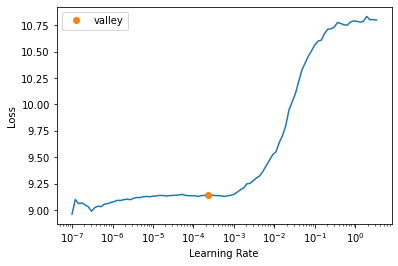

In [3]:
# Define the loss function
dls = get_dls()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = classification_model(dls.c).to(device)
loss_func = NormSoftmaxLoss().to(device)

# Define the recall metric
recall_metric = AccumMetric(recallat10, dim_argmax = -1)

# Define the learner
learn = Learner(dls, model, loss_func, splitter = effnet_splitter, metrics = [accuracy, recall_metric])
learn.freeze_to(-2)
learn.lr_find()

In [4]:
learn.fit_one_cycle(5, 3e-4, cbs = [SaveModelCallback()])

epoch,train_loss,valid_loss,accuracy,recallat10,time
0,9.374063,9.343337,0.000000,0.323156,08:16
1,9.172375,9.125726,0.000000,0.405301,11:02
2,8.059314,7.814932,0.026042,0.435911,08:13
3,7.538287,7.299446,0.052083,0.500775,07:10
4,7.394789,7.199810,0.065104,0.506975,07:25


Better model found at epoch 0 with valid_loss value: 9.343337059020996.
Better model found at epoch 1 with valid_loss value: 9.125725746154785.
Better model found at epoch 2 with valid_loss value: 7.814932346343994.
Better model found at epoch 3 with valid_loss value: 7.299446105957031.
Better model found at epoch 4 with valid_loss value: 7.199809551239014.


SuggestedLRs(valley=4.786300905834651e-06)

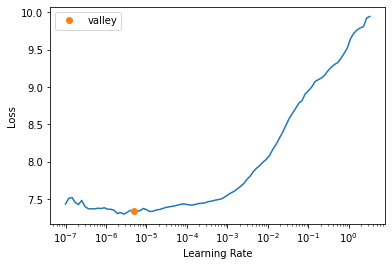

In [5]:
learn.unfreeze()
learn.lr_find()

In [7]:
learn.export("../inshop_classification_baseline_frozen.pkl")

In [8]:
learn.fit_one_cycle(20, 5e-4, cbs = [SaveModelCallback()])

epoch,train_loss,valid_loss,accuracy,recallat10,time
0,7.541043,7.272987,0.072917,0.669792,09:13
1,7.317745,7.096011,0.080729,0.724892,09:01
2,6.895531,6.744589,0.088542,0.778363,08:57
3,6.393095,6.139523,0.125000,0.828115,16:44
4,5.552650,5.459272,0.179688,0.846869,09:03
5,4.849602,4.738389,0.276042,0.890189,08:25
6,4.263824,4.591637,0.309896,0.897164,09:54
7,3.793914,4.360951,0.388021,0.889492,08:40
8,3.268465,3.467518,0.494792,0.906541,07:45
9,2.799161,2.730831,0.617188,0.932347,07:57


Better model found at epoch 0 with valid_loss value: 7.272987365722656.
Better model found at epoch 1 with valid_loss value: 7.096010684967041.
Better model found at epoch 2 with valid_loss value: 6.744588851928711.
Better model found at epoch 3 with valid_loss value: 6.139522552490234.
Better model found at epoch 4 with valid_loss value: 5.4592719078063965.
Better model found at epoch 5 with valid_loss value: 4.738388538360596.
Better model found at epoch 6 with valid_loss value: 4.591637134552002.
Better model found at epoch 7 with valid_loss value: 4.360950946807861.
Better model found at epoch 8 with valid_loss value: 3.467517852783203.
Better model found at epoch 9 with valid_loss value: 2.7308309078216553.
Better model found at epoch 11 with valid_loss value: 2.2619590759277344.
Better model found at epoch 12 with valid_loss value: 1.6536785364151.
Better model found at epoch 13 with valid_loss value: 1.3388423919677734.
Better model found at epoch 14 with valid_loss value: 0.948

In [10]:
learn.export("../inshop_classification_baseline_unfrozen.pkl")

SuggestedLRs(valley=6.30957365501672e-05)

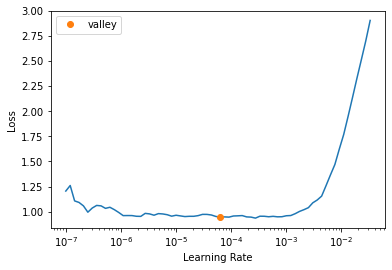

In [11]:
learn.unfreeze()
learn.lr_find()

In [12]:
learn.fit_one_cycle(20, 1e-4, cbs = [SaveModelCallback()])

epoch,train_loss,valid_loss,accuracy,recallat10,time
0,0.999166,0.521784,0.968750,0.963577,08:30
1,0.987256,0.507536,0.973958,0.961717,08:35
2,0.961016,0.608505,0.960938,0.952883,07:44
3,0.948867,0.447736,0.979167,0.962802,08:59
4,0.908665,0.459869,0.979167,0.959005,08:54
5,0.834435,0.352218,0.986979,0.961097,08:29
6,0.727094,0.404311,0.986979,0.954898,08:00
7,0.669033,0.265550,0.989583,0.959315,09:54
8,0.605437,0.218392,0.997396,0.962027,08:19
9,0.537093,0.165525,1.000000,0.965360,08:25


Better model found at epoch 0 with valid_loss value: 0.5217835903167725.
Better model found at epoch 1 with valid_loss value: 0.5075358152389526.
Better model found at epoch 3 with valid_loss value: 0.4477361738681793.
Better model found at epoch 5 with valid_loss value: 0.35221800208091736.
Better model found at epoch 7 with valid_loss value: 0.26554951071739197.
Better model found at epoch 8 with valid_loss value: 0.21839244663715363.
Better model found at epoch 9 with valid_loss value: 0.16552495956420898.
Better model found at epoch 10 with valid_loss value: 0.13888664543628693.
Better model found at epoch 11 with valid_loss value: 0.12398605793714523.
Better model found at epoch 13 with valid_loss value: 0.0914773941040039.
Better model found at epoch 14 with valid_loss value: 0.07935921102762222.
Better model found at epoch 15 with valid_loss value: 0.06886151432991028.
Better model found at epoch 16 with valid_loss value: 0.06407652795314789.
Better model found at epoch 17 with 

In [14]:
learn.export("../inshop_classification_baseline_unfrozen.pkl")